# Estimate the Correct Number of Published Preprints

In [1]:
from pathlib import Path

import lxml.etree as ET
import numpy as np
import pandas as pd
import plotnine as p9
from tqdm import tqdm

# Load Abdil et al. Score

In [2]:
file_path = "https://elifesciences.org/download/aHR0cHM6Ly9jZG4uZWxpZmVzY2llbmNlcy5vcmcvYXJ0aWNsZXMvNDUxMzMvZWxpZmUtNDUxMzMtZmlnMy1kYXRhMS12Mi5jc3Y-/elife-45133-fig3-data1-v2.csv?_hash=6d5MoXPaQXFZiifDTRaKXoZ29OnVUJq%2FuoHlyuh%2Bg04%3D"

In [3]:
abdill_df = pd.read_csv(file_path)
abdill_df.head(10)

,month,posted,published,rate
0,2013-11,60,35,0.583333
1,2013-12,49,36,0.734694
2,2014-01,54,32,0.592593
3,2014-02,66,45,0.681818
4,2014-03,43,34,0.790698
5,2014-04,66,40,0.606061
6,2014-05,81,54,0.666667
7,2014-06,72,46,0.638889
8,2014-07,67,46,0.686567
9,2014-08,80,55,0.687500


# Current Estimated Published Fraction

## Gather all published preprints

In [4]:
biorxiv_journal_df = (
    pd.read_csv(
        Path("../journal_tracker")
        / Path("output/mapped_published_doi_before_update.tsv"),
        sep="\t",
    )
    .rename(index=str, columns={"doi": "preprint_doi"})
    .groupby("preprint_doi")
    .agg(
        {
            "document": "first",
            "category": "first",
            "preprint_doi": "last",
            "published_doi": "first",
            "pmcid": "first",
            "pmcoa": "first",
        }
    )
    .reset_index(drop=True)
    .assign(published=lambda x: x.published_doi.apply(lambda y: "/" in str(y)))
)
print(biorxiv_journal_df.shape)
biorxiv_journal_df.head()

(71118, 7)


,document,category,preprint_doi,published_doi,pmcid,pmcoa,published
0,000026_v1.xml,genetics,10.1101/000026,10.1371/journal.pgen.1004412,PMC4125079,True,True
1,000042_v1.xml,genomics,10.1101/000042,10.1038/nrg3723,PMC4151119,False,True
2,000067_v1.xml,genomics,10.1101/000067,10.1038/nature12904,PMC4285441,True,True
3,000091_v1.xml,synthetic biology,10.1101/000091,NaN,NaN,False,False
4,000109_v1.xml,evolutionary biology,10.1101/000109,10.1371/journal.pgen.1004410,PMC4072524,True,True


In [5]:
print(f"Total Published: {biorxiv_journal_df.published.sum()}")
print(f"Total Published in PMCOA: {biorxiv_journal_df.pmcoa.sum()}")

Total Published: 31385
Total Published in PMCOA: 17952


In [6]:
annotated_links_df = (
    pd.read_csv(
        Path("output") / Path("potential_biorxiv_pmc_links_rerun.tsv"), sep="\t"
    )
    .assign(published=True)
    .rename(index=str, columns={"biorxiv_doi": "preprint_doi"})[
        ["document", "preprint_doi", "published", "distance_bin"]
    ]
)
print(annotated_links_df.shape)
annotated_links_df.head()

(7213, 4)


,document,preprint_doi,published,distance_bin
0,000836_v1.xml,10.1101/000836,True,"[25%ile, 50%ile)"
1,003129_v1.xml,10.1101/003129,True,"[25%ile, 50%ile)"
2,002261_v1.xml,10.1101/002261,True,"[25%ile, 50%ile)"
3,001719_v1.xml,10.1101/001719,True,"[50%ile, 75%ile)"
4,004291_v1.xml,10.1101/004291,True,"[50%ile, 75%ile)"


In [7]:
missing_link_mapper = {
    row["preprint_doi"]: [row["published"], True]
    for row in (
        annotated_links_df.query("distance_bin in ['[0, 25%ile)', '[25%ile, 50%ile)']")[
            ["preprint_doi", "published"]
        ].to_dict(orient="records")
    )
}
new_link_count = len(missing_link_mapper)
print(f"Novel links filled: {new_link_count}")

Novel links filled: 1542


In [8]:
remaining_links = {
    row["preprint_doi"]: [row["published"], row["pmcoa"]]
    for row in (
        biorxiv_journal_df[["preprint_doi", "published", "pmcoa"]].to_dict(
            orient="records"
        )
    )
    if row["preprint_doi"] not in missing_link_mapper
}
print(len(remaining_links))

69576


In [9]:
missing_link_mapper.update(remaining_links)
print(len(missing_link_mapper))

71118


In [10]:
updated_biorxiv_journal_df = pd.DataFrame.from_records(
    [
        {"preprint_doi": row[0], "published": row[1][0], "pmcoa": row[1][1]}
        for row in list(missing_link_mapper.items())
    ]
).merge(biorxiv_journal_df.drop(["published", "pmcoa"], axis=1), on="preprint_doi")
print(updated_biorxiv_journal_df.shape)
updated_biorxiv_journal_df.head()

(71118, 7)


,preprint_doi,published,pmcoa,document,category,published_doi,pmcid
0,10.1101/000836,True,True,000836_v1.xml,cell biology,NaN,NaN
1,10.1101/003129,True,True,003129_v1.xml,plant biology,NaN,NaN
2,10.1101/002261,True,True,002261_v1.xml,genomics,NaN,NaN
3,10.1101/004960,True,True,004960_v1.xml,systems biology,NaN,NaN
4,10.1101/007765,True,True,007765_v1.xml,evolutionary biology,NaN,NaN


## Gather date published for each document

In [11]:
file_path = Path("output/biorxiv_articles_published_date.tsv")

In [12]:
if not file_path.exists():
    data_records = []
    xml_parser = ET.XMLParser(encoding="UTF-8", recover=True)
    for document in tqdm(updated_biorxiv_journal_df.document.tolist()):
        root = ET.parse(f"../biorxiv_articles/{document}", parser=xml_parser).getroot()

        date_node = root.xpath("//front/article-meta/history/date")

        if len(date_node) == 0:
            print("Error in xml:")
            print(document)
            continue

        elif len(date_node) < 2:
            date_node = date_node[0]

        else:
            date_node = date_node[1]

        data_row = dict(map(lambda x: (x.tag, x.text), date_node.getchildren()))

        data_records.append(
            {
                "month": f"{data_row['year']}-{int(data_row['month']):02d}",
                "document": document,
            }
        )

In [13]:
if not file_path.exists():
    published_preprint_df = pd.DataFrame.from_records(
        data_records
        + [
            {"month": "2018-09", "document": "423517_v1.xml"},
            {"month": "2019-01", "document": "528299_v1.xml"},
        ]
    )
else:
    published_preprint_df = pd.read_csv(file_path, sep="\t")
print(published_preprint_df.shape)
published_preprint_df.head()

(71118, 9)


,pub_month,document,doi,published,pmcoa,category,journal,published_doi,pmcid
0,2014-01,002097_v1.xml,10.1101/002097,True,True,bioinformatics,NaN,NaN,NaN
1,2019-03,568642_v1.xml,10.1101/568642,True,True,developmental biology,NaN,NaN,NaN
2,2019-03,567537_v1.xml,10.1101/567537,True,True,epidemiology,NaN,NaN,NaN
3,2019-03,568477_v1.xml,10.1101/568477,True,True,microbiology,NaN,NaN,NaN
4,2018-12,490409_v1.xml,10.1101/490409,True,True,neuroscience,NaN,NaN,NaN


In [14]:
if not file_path.exists():
    final_mapped_df = published_preprint_df.merge(
        updated_biorxiv_journal_df, on="document"
    ).rename(index=str, columns={"month": "pub_month"})
    print(final_mapped_df.shape)
else:
    final_mapped_df = (
        published_preprint_df[["document", "pub_month"]]
        .merge(updated_biorxiv_journal_df, on="document", how="left")
        .rename(index=str, columns={"month": "pub_month"})
    )
    print(final_mapped_df.shape)

final_mapped_df

(71118, 8)


,document,pub_month,preprint_doi,published,pmcoa,category,published_doi,pmcid
0,002097_v1.xml,2014-01,10.1101/002097,False,False,bioinformatics,NaN,NaN
1,568642_v1.xml,2019-03,10.1101/568642,True,True,developmental biology,NaN,NaN
2,567537_v1.xml,2019-03,10.1101/567537,True,True,epidemiology,NaN,NaN
3,568477_v1.xml,2019-03,10.1101/568477,True,True,microbiology,NaN,NaN
4,490409_v1.xml,2018-12,10.1101/490409,True,True,neuroscience,NaN,NaN
...,...,...,...,...,...,...,...,...
71113,872952_v1.xml,2019-12,10.1101/872952,False,False,cell biology,NaN,NaN
71114,873109_v1.xml,2019-12,10.1101/873109,False,False,developmental biology,NaN,NaN
71115,873232_v1.xml,2019-12,10.1101/873232,False,False,developmental biology,NaN,NaN
71116,423517_v1.xml,2018-09,10.1101/423517,False,False,epidemiology,NaN,NaN


In [15]:
if not file_path.exists():
    (
        final_mapped_df.to_csv(
            "output/biorxiv_articles_published_date.tsv", sep="\t", index=False
        )
    )

In [16]:
# replacing 2013-10 with 2013-11 as bioRxiv officially started in nov 2013
snapshot_wo_links_df = (
    biorxiv_journal_df.assign(published_closed=lambda x: (x.pmcoa != x.published))
    .merge(final_mapped_df[["document", "pub_month"]], on="document")
    .replace({"2013-10": "2013-11"})
    .groupby("pub_month")
    .agg(
        {
            "published": lambda x: x.sum(),
            "pub_month": "count",
            "published_closed": lambda x: x.sum(),
        }
    )
    .rename(index=str, columns={"pub_month": "posted"})
    .reset_index()
    .assign(label="2020 Snapshot", rate=lambda x: x.published / x.posted)
)
snapshot_wo_links_df.head()

,pub_month,published,posted,published_closed,label,rate
0,2013-11,27,49,12,2020 Snapshot,0.551020
1,2013-12,33,42,12,2020 Snapshot,0.785714
2,2014-01,31,50,14,2020 Snapshot,0.620000
3,2014-02,40,60,15,2020 Snapshot,0.666667
4,2014-03,32,43,13,2020 Snapshot,0.744186


In [17]:
snapshot_w_links_df = (
    final_mapped_df.replace({"2013-10": "2013-11"})
    .groupby("pub_month")
    .agg({"published": lambda x: x.sum(), "pub_month": "count"})
    .rename(index=str, columns={"pub_month": "posted"})
    .reset_index()
    .assign(rate=lambda x: x.published / x.posted, label="2020 Snapshot+Missing Links")
)
snapshot_w_links_df.head()

,pub_month,published,posted,rate,label
0,2013-11,28,49,0.571429,2020 Snapshot+Missing Links
1,2013-12,33,42,0.785714,2020 Snapshot+Missing Links
2,2014-01,32,50,0.640000,2020 Snapshot+Missing Links
3,2014-02,41,60,0.683333,2020 Snapshot+Missing Links
4,2014-03,32,43,0.744186,2020 Snapshot+Missing Links


## Calculate the publication rate

In [18]:
publish_rate_df = (
    snapshot_w_links_df.append(
        abdill_df.assign(label="Abdill et al. (2018)").rename(
            index=str, columns={"month": "pub_month"}
        ),
        sort=False,
    )
    .append(snapshot_wo_links_df.drop("published_closed", axis=1))
    .reset_index(drop=True)
)
publish_rate_df.sample(10, random_state=100)

,pub_month,published,posted,rate,label
115,2017-03,560,812,0.689655,Abdill et al. (2018)
41,2017-04,515,715,0.720280,2020 Snapshot+Missing Links
173,2016-12,358,527,0.679317,2020 Snapshot
83,2014-07,46,67,0.686567,Abdill et al. (2018)
111,2016-11,316,463,0.682505,Abdill et al. (2018)
65,2019-04,951,2283,0.416557,2020 Snapshot+Missing Links
165,2016-04,204,318,0.641509,2020 Snapshot
110,2016-10,311,455,0.683516,Abdill et al. (2018)
178,2017-05,628,904,0.694690,2020 Snapshot
160,2015-11,146,217,0.672811,2020 Snapshot


In [19]:
publish_rate_df["pub_month"] = pd.Categorical(
    publish_rate_df.pub_month.values.tolist(), ordered=True
)

posted = publish_rate_df.query("label=='2020 Snapshot+Missing Links'").posted.sum()

published = publish_rate_df.query(
    "label=='2020 Snapshot+Missing Links'"
).published.sum()
print(f"Published: {published}")
print(f"Posted: {posted}")
print(f"Overall proportion published: {published/posted:.4f}")

Published: 32927
Posted: 71118
Overall proportion published: 0.4630


# Plot Publication Rate

In [20]:
color_mapper = {
    "2018": "#a6cee3",
    "2020ML": "#33a02c",
    "2020": "#1f78b4",
}

/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 11 x 6.5 in image.
/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: output/figures/publication_rate.svg
/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 11 x 6.5 in image.
/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: output/figures/publication_rate.png


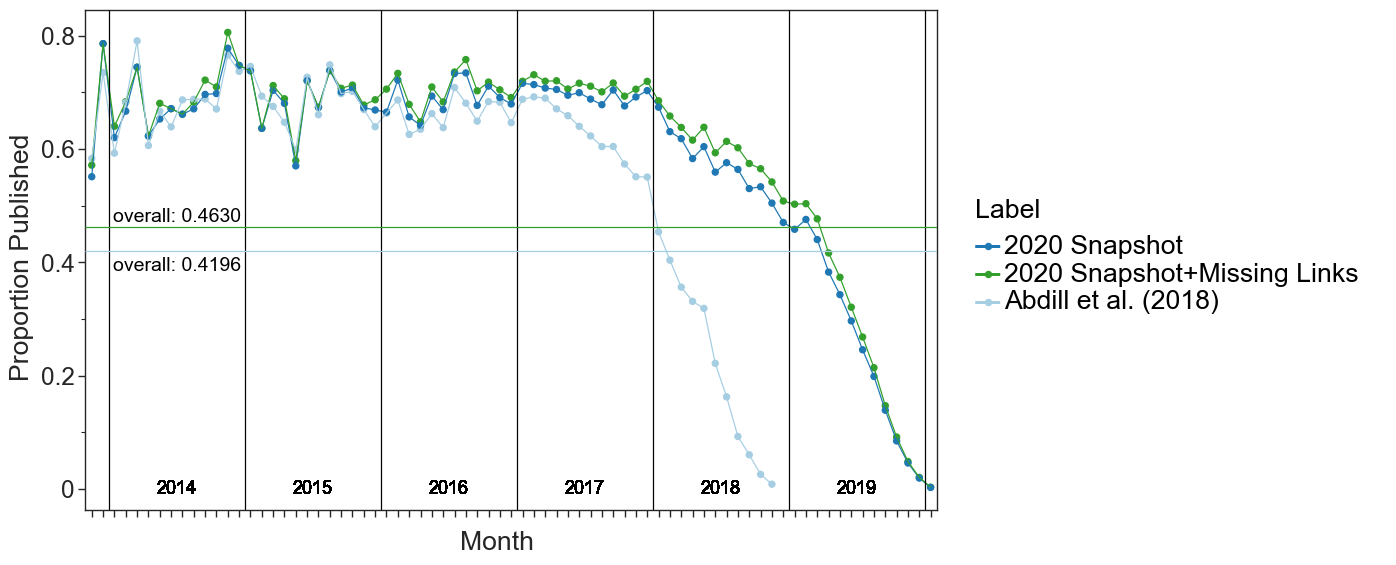

<ggplot: (-9223363288655596179)>


In [21]:
g = (
    p9.ggplot(publish_rate_df.rename(index=str, columns={"label": "Label"}))
    + p9.aes(
        x="pub_month",
        y="rate",
        fill="Label",
        group="Label",
        color="Label",
        linetype="Label",
        shape="Label",
    )
    + p9.geom_point(size=2)
    + p9.geom_line()
    + p9.scale_linetype_manual(["solid", "solid", "solid"])
    + p9.scale_color_manual(
        [color_mapper["2020"], color_mapper["2020ML"], color_mapper["2018"]]
    )
    + p9.scale_fill_manual(
        [color_mapper["2020"], color_mapper["2020ML"], color_mapper["2018"]]
    )
    + p9.scale_shape_manual(["o", "o", "o"])
    # plot the x axis titles
    + p9.geom_vline(xintercept=[2.5, 14.5, 26.5, 38.5, 50.5, 62.5, 74.5])
    + p9.geom_text(label="2014", x=8.5, y=0, color="black", size=13)
    + p9.geom_text(label="2015", x=20.5, y=0, color="black", size=13)
    + p9.geom_text(label="2016", x=32.5, y=0, color="black", size=13)
    + p9.geom_text(label="2017", x=44.5, y=0, color="black", size=13)
    + p9.geom_text(label="2018", x=56.5, y=0, color="black", size=13)
    + p9.geom_text(label="2019", x=68.5, y=0, color="black", size=13)
    # Plot the overall proportion published
    + p9.geom_hline(yintercept=0.4196, linetype="solid", color=color_mapper["2018"])
    + p9.geom_hline(
        yintercept=published / posted, linetype="solid", color=color_mapper["2020ML"]
    )
    + p9.annotate("text", x=8.5, y=0.395, label="overall: 0.4196", size=14)
    + p9.annotate(
        "text", x=8.5, y=0.48, label=f"overall: {published/posted:.4f}", size=14
    )
    + p9.theme_seaborn(style="ticks", context="paper", font="Arial", font_scale=2)
    + p9.theme(
        figure_size=(11, 6.5),
        axis_text_x=p9.element_blank(),
        axis_title_x=p9.element_text(margin={"t": 15}),
    )
    + p9.labs(y="Proportion Published", x="Month")
)
g.save("output/figures/publication_rate.svg")
g.save("output/figures/publication_rate.png", dpi=250)
print(g)

# Plot Publication Rate

In [22]:
publish_rate_df["pub_month"] = pd.Categorical(
    publish_rate_df.pub_month.values.tolist(), ordered=True
)

posted = (
    publish_rate_df.query("label=='2020 Snapshot+Missing Links'")
    .query("pub_month < '2019-01'")
    .posted.sum()
)

published = (
    publish_rate_df.query("label=='2020 Snapshot+Missing Links'")
    .query("pub_month < '2019-01'")
    .published.sum()
)
print(f"Published: {published}")
print(f"Posted: {posted}")
print(f"Overall proportion published: {published/posted:.4f}")

Published: 24854
Posted: 38335
Overall proportion published: 0.6483


In [23]:
color_mapper = {
    "2018": "#a6cee3",
    "2020ML": "#33a02c",
    "2020": "#1f78b4",
}

/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 11 x 6.5 in image.
/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: output/figures/publication_rate_reviewer_request.svg
/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 11 x 6.5 in image.
/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: output/figures/publication_rate_reviewer_request.png


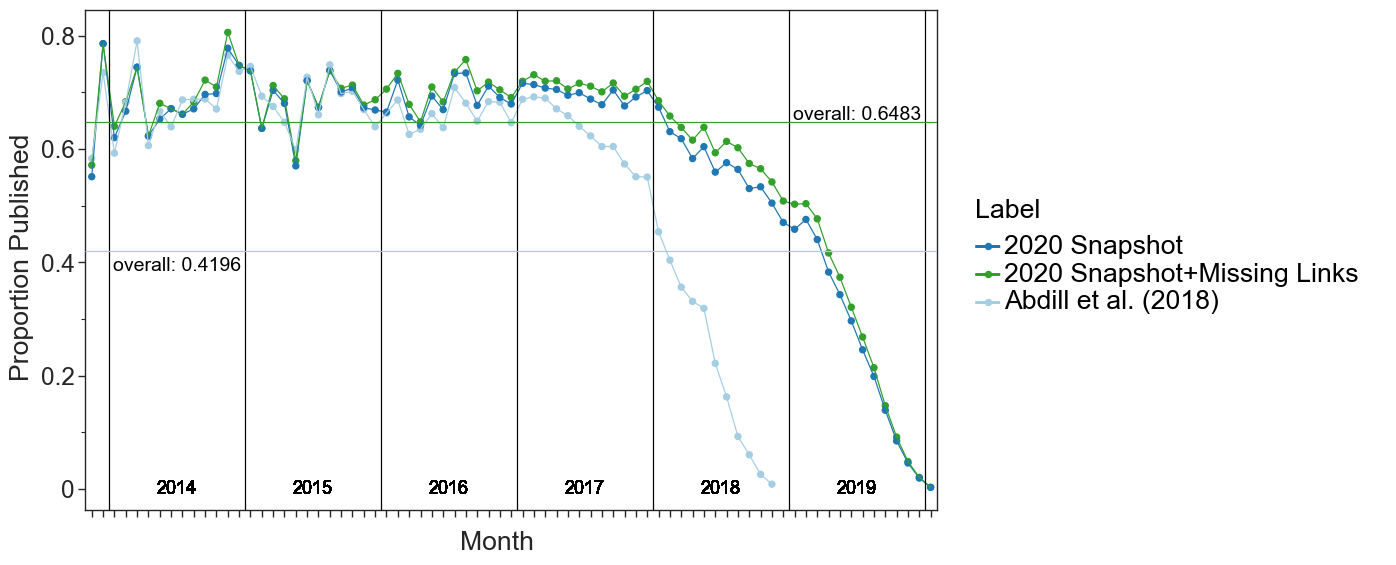

<ggplot: (-9223363288663620513)>


In [25]:
g = (
    p9.ggplot(publish_rate_df.rename(index=str, columns={"label": "Label"}))
    + p9.aes(
        x="pub_month",
        y="rate",
        fill="Label",
        group="Label",
        color="Label",
        linetype="Label",
        shape="Label",
    )
    + p9.geom_point(size=2)
    + p9.geom_line()
    + p9.scale_linetype_manual(["solid", "solid", "solid"])
    + p9.scale_color_manual(
        [color_mapper["2020"], color_mapper["2020ML"], color_mapper["2018"]]
    )
    + p9.scale_fill_manual(
        [color_mapper["2020"], color_mapper["2020ML"], color_mapper["2018"]]
    )
    + p9.scale_shape_manual(["o", "o", "o"])
    # plot the x axis titles
    + p9.geom_vline(xintercept=[2.5, 14.5, 26.5, 38.5, 50.5, 62.5, 74.5])
    + p9.geom_text(label="2014", x=8.5, y=0, color="black", size=13)
    + p9.geom_text(label="2015", x=20.5, y=0, color="black", size=13)
    + p9.geom_text(label="2016", x=32.5, y=0, color="black", size=13)
    + p9.geom_text(label="2017", x=44.5, y=0, color="black", size=13)
    + p9.geom_text(label="2018", x=56.5, y=0, color="black", size=13)
    + p9.geom_text(label="2019", x=68.5, y=0, color="black", size=13)
    # Plot the overall proportion published
    + p9.geom_hline(yintercept=0.4196, linetype="solid", color=color_mapper["2018"])
    + p9.geom_hline(
        yintercept=published / posted, linetype="solid", color=color_mapper["2020ML"]
    )
    + p9.annotate("text", x=8.5, y=0.395, label="overall: 0.4196", size=14)
    + p9.annotate(
        "text", x=68.5, y=0.66, label=f"overall: {published/posted:.4f}", size=14
    )
    + p9.theme_seaborn(style="ticks", context="paper", font="Arial", font_scale=2)
    + p9.theme(
        figure_size=(11, 6.5),
        axis_text_x=p9.element_blank(),
        axis_title_x=p9.element_text(margin={"t": 15}),
    )
    + p9.labs(y="Proportion Published", x="Month")
)
g.save("output/figures/publication_rate_reviewer_request.svg")
g.save("output/figures/publication_rate_reviewer_request.png", dpi=250)
print(g)